In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import clear_output
import pandas as pd
import copy
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import *

---

<font size="5">Overviews</font>
1. Introduction
1. Dataset
1. Preparation
1. Classification

---

# Introduction
---
In this notebook, I'm going to explain the basic procedure of classification including dataset implementation, preparation of training, and classification. For the sake of tidiness, I won't explain the detail of some functions, so, please visit `Week_05_PyTorch/pyfiles/` for further information. Before you start to run the code below, make sure you've stored the dataset we're going to use, which is available [here](https://drive.google.com/drive/folders/1VBSpK6ekzg9eqlNyoUQyP3GKySyd2w8g?usp=sharing). And put it into below `Week_05_PyTorch`. 

---

# Dataset
---

Ok, this experiment is conducted with [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). However, I've modified it for our use. Fashion MNIST contains 10 classes as you can see below. The original shape is 28x28 and it has only 1 channel for shade. As for data augmentation, RandomHorizontalFlip is employed for training and validation datasets. It's resized to 32x32 in all datasets and normalized to make its min and max -1 and 1 respectively. You can define your data augmentation and preprocesses as `transform` as illustrated below.

---

In [3]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(mean0=True),
])
    
transform["test"] = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    MinMax(mean0=True),
])

---
In PyTorch implementation, `Dataset` is required for training and inference. Some datasets have their own implementation in PyTorch such as MNIST, CIFAR10, and even FashionMNIST. However, understandably, you're going to use a dataset that is not available in PyTorch. In this section, I'll teach you how to implement your dataset function.

Again, in this notebook, I'm going to use the dataset which is available [here](https://drive.google.com/drive/folders/1VBSpK6ekzg9eqlNyoUQyP3GKySyd2w8g?usp=sharing), please download it before going forward. 
First of all, this dataset originated from Fashion MNIST, and it was modified to be smaller and easy to implement. The modification is detailed in `notebooks/A_build_dataset1.ipynb`. The main folder is composed of 10 folders and each of them contains all data in a certain class. The tree structure is:
```
fashion_dataset1
├── 1
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 2
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 3
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── ...
```

*Dataset* can be mainly divided into 2 sections; initialization and calling. It'll process the initialization step only when you call the function at the beginning, so you should put lengthy computation in this section. On the other hand, in the calling section or `__getitem__`, it'll be processed every iteration of training, so obviously, it should be as simple as possible. Needless to say, data augmentation computation is included in `__getitem__` to alter the data. However, due to the limitation of memory capacity, all data can't be stored simultaneously, so I recommend to store the path of the images in the initialization step and open it in the calling section. 

---

In [4]:
class Dataset_Fashion_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, classes, mode="train", transform=None, balance=[0.7,0.15,0.15], each_data_num=10000000):
        
        self.transform = transform
        self.images = []
        self.labels = []

        images = {} 
        labels = {}
        
        for cl in classes:
            path_list = glob.glob(root + f"{cl}/*")
            path_list.sort()
            path_list = path_list[:each_data_num]
            train_num = int(balance[0]*len(path_list))
            val_num = int(balance[1]*len(path_list))
            test_num = int(balance[2]*len(path_list))
            if mode=="train":
                path_list = path_list[:train_num]
            elif mode=="val":
                path_list = path_list[train_num:train_num+val_num]
            elif mode=="test":
                path_list = path_list[-test_num:]
            images[str(cl)] = path_list
            labels[str(cl)] = [cl]*len(path_list)
            
        # combine them together
        for label in classes:
            for image, label in zip(images[str(label)], labels[str(label)]):
                self.images.append(image)
                self.labels.append(label)

    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert("L")
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)

---
Define some variables including path of the dataset and the class labels.

---

In [5]:
root = "../fashion_dataset1/"
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
classes = range(len(class_labels))

In [6]:
dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"])

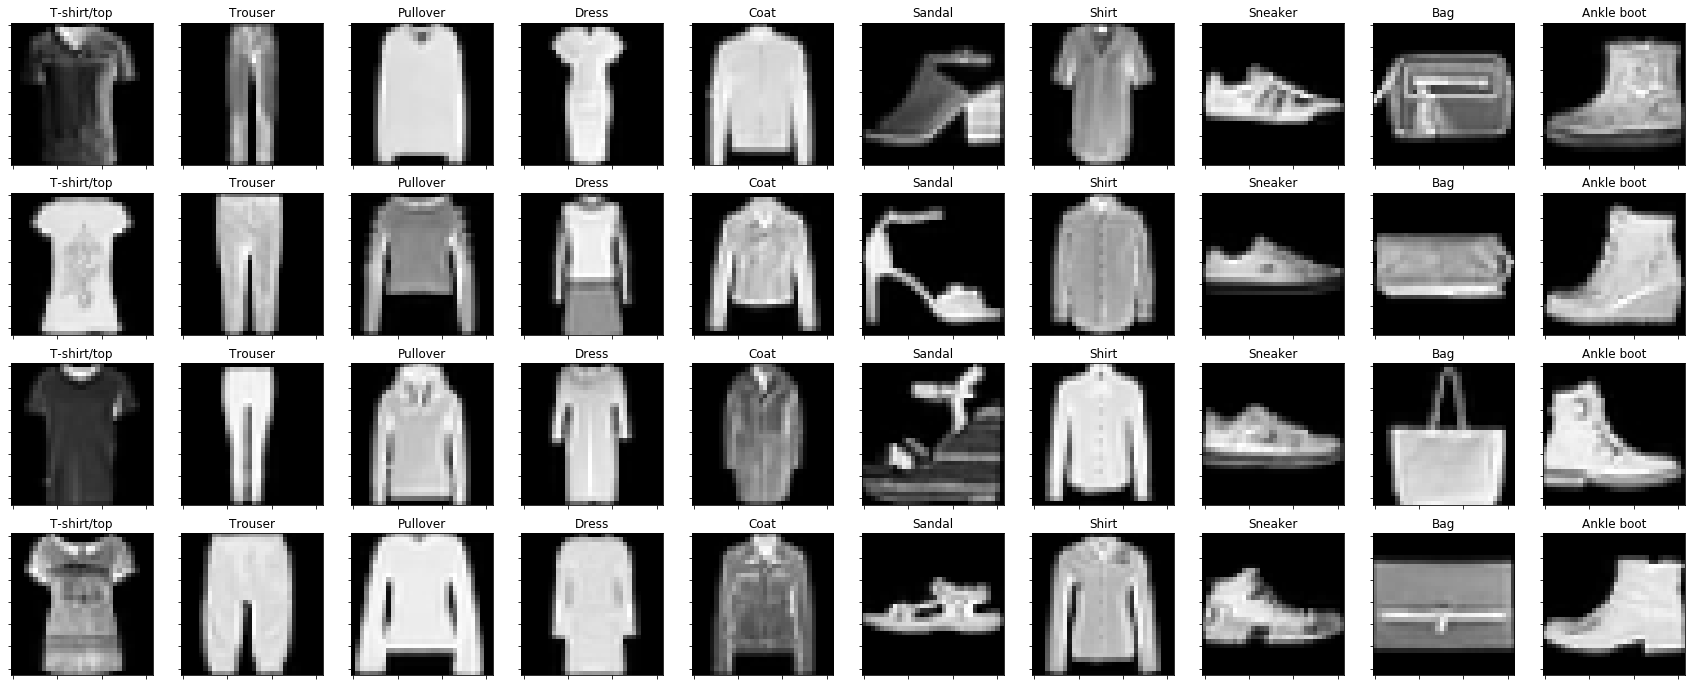

In [7]:
display_num = 4
each_num = int(len(dataset)/len(classes))
fig = plt.figure(figsize=(30, 12))
for i in range(display_num):
    for cl in classes:
        ax = fig.add_subplot(display_num, len(classes), len(classes)*i+cl+1)
        index = np.random.randint(0,each_num)+cl*each_num
        x, label = dataset[index]
        ax.imshow(image_from_numpy(cuda2numpy(x[np.newaxis]))[0])
        ax.set_title(f"{class_labels[cl]}")
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

# Preparation
---
Ok, so let's take a look at the model structures and some algorithms for training.

---

## Model Structure
---
To begin with the model structure, in the future, you might want to imitate the model in a paper, but sometimes it has no model available on the internet. In this case, you'll have to implement the model from a diagram or a text instruction from the paper. So, let's practice it. This ability is also quite important when you build your own model. 

---

The instruction is shown below in a form of a diagram and a procedure. 

`image`

- the model consists of 3 convolutional blocks and 3 fully connected layers.
- each convolutional block has a convolutional layer and a max pooling layer.
- ReLU is employed as an activation function except for the final layer.
- Of course, this is classification task, so you should use Softmax function in the last computation.

---

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.reshape(x.size(0), -1)

In [9]:
class ConvolutionalBlock(nn.Module):
    
    def __init__(self, nch_in, nch_out, kernel, activation="ReLU"):
        super(ConvolutionalBlock, self).__init__()
        layers = [
            nn.Conv2d(nch_in, nch_out, kernel_size=kernel, stride=1, padding=int((kernel-1)/2)),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        if activation=="ReLU":
            layers.append(nn.ReLU())
        elif activation=="Tanh":
            layers.append(nn.Tanh())
        elif activation=="Sigmoid":
            layers.append(nn.Sigmoid())
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [10]:
class Classifier(nn.Module):
    
    def __init__(self, in_nch, out_nch, nch, kernel=3, activation="ReLU"):
        super(Classifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            ConvolutionalBlock(in_nch, nch, kernel, activation),
            ConvolutionalBlock(nch, nch*2, kernel, activation),
            ConvolutionalBlock(nch*2, nch*4, kernel, activation),
        )
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(4*4*(nch*4), out_nch),
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fcs(x)
        return x

---
In order to focus on training process in the main code, I first implemented the function which conducts test process.

---

In [11]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = cuda2numpy(data[1])
            output = cuda2numpy(net(images))
            if itr==0:
                outputs = output
            else:
                outputs = np.concatenate([outputs, output], axis=0)
            labels = np.append(labels, label)
    return labels, outputs

---
Well, next, some hyperparameters for training are mentioned in the first cell, and these for the model are shown in the second cell.

---

In [12]:
epoch_num = 301
lr = 0.001
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
in_nch = 1 # the number of color channels
out_nch = len(classes) # the number of output channels, in this case, classes
nch = 16

---
some algorithms are employed for optimization, loss function, and scheduler.
- optimizer: Adam optimizer with default parameters
- scheduler: learning rate scheduler which lowers the lr exponentially
- loss function: Cross Entropy Loss (CELoss)

---

In [14]:
net = Classifier(in_nch, out_nch, nch)
net = net.to(device)
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
This is the preparation of the dataset. *Dataloader* combines the individual data and into batch-sized data. And also it shuffles them if you want.

---

In [15]:
# ----- adjustable parameters ----- #
each_data_num = 2000
train_batch = 512
val_batch = 512
# --------------------------------- #

dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"], each_data_num=each_data_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_Fashion_MNIST(root, classes, "val", transform["train"], each_data_num=each_data_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(14000, 3000)

# Classification
---
Let's train your model.
The notebook gives you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.

---

300
test acc in 300 : 0.8386666666666667
best acc is   : 0.8436666666666667 in epoch84


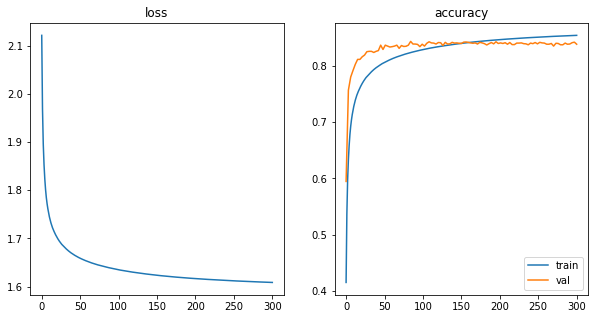

In [16]:
net.train()
losses = []
losses_epoch = []
accs = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), 
                       f"../instant_parameters/classifier_nch{nch}_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

## Result
---
It seems to be successful, but there's a little signs of over-fitting.
Since this is lengthy process, I've finished and saved the parameters of the best validation accuracy in advance.
Let's call it in the code below.


---

In [36]:
load_parameter = True
if load_parameter:
#     model_path = f"../data/parameters/emorec_fs22050_uniwavenet_precausal_nchin1_prefilter3_res_in16_hidden4_out8_nchhidden16_nchout4_wavenetln20_fsize3_reduce8_cnnnum3_input32768_epoch171.pth"
    model_path = f"../instant_parameters/classifier_nch16_lr0.001_epoch291.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [37]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_Fashion_MNIST(root, classes, "test", transform["test"], each_data_num=each_data_num)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=train_batch, shuffle=True)
len(testset)

3000

---
Evaluate it many times.

---

In [40]:
# ----- adjustable parameters ----- #
test_num = 100
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.8419999999999999


---
Check the detail (confusion matrix)

---

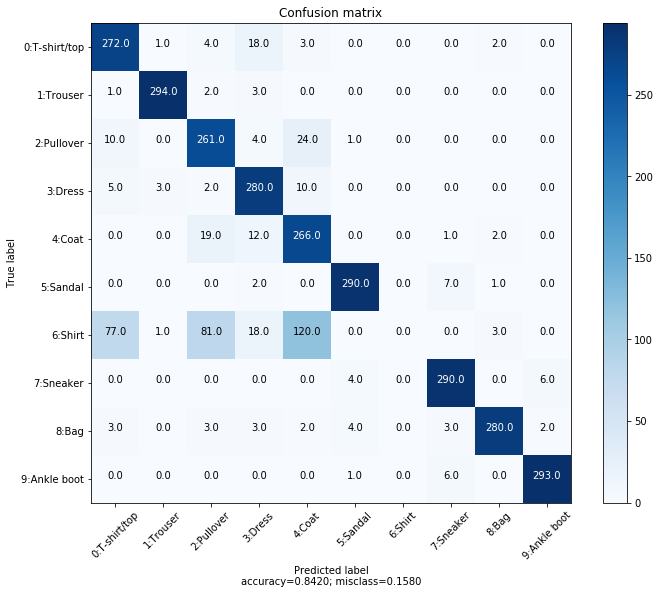

In [111]:
class_idx_lbl = class_labels.copy()
for i in range(len(class_labels)):
    class_idx_lbl[i] = f"{i}:{class_labels[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

---
The accuracy is quite good enough.
As the result, "happy", "sad" or "neutral" voice sometimes classified as "angry", "neutral", or "happy" respectively.
The 2 formers are relatively understandable compared to the latter one.

---

## Misclassification


the samples of 'Shirt' which are classified as 'Coat''



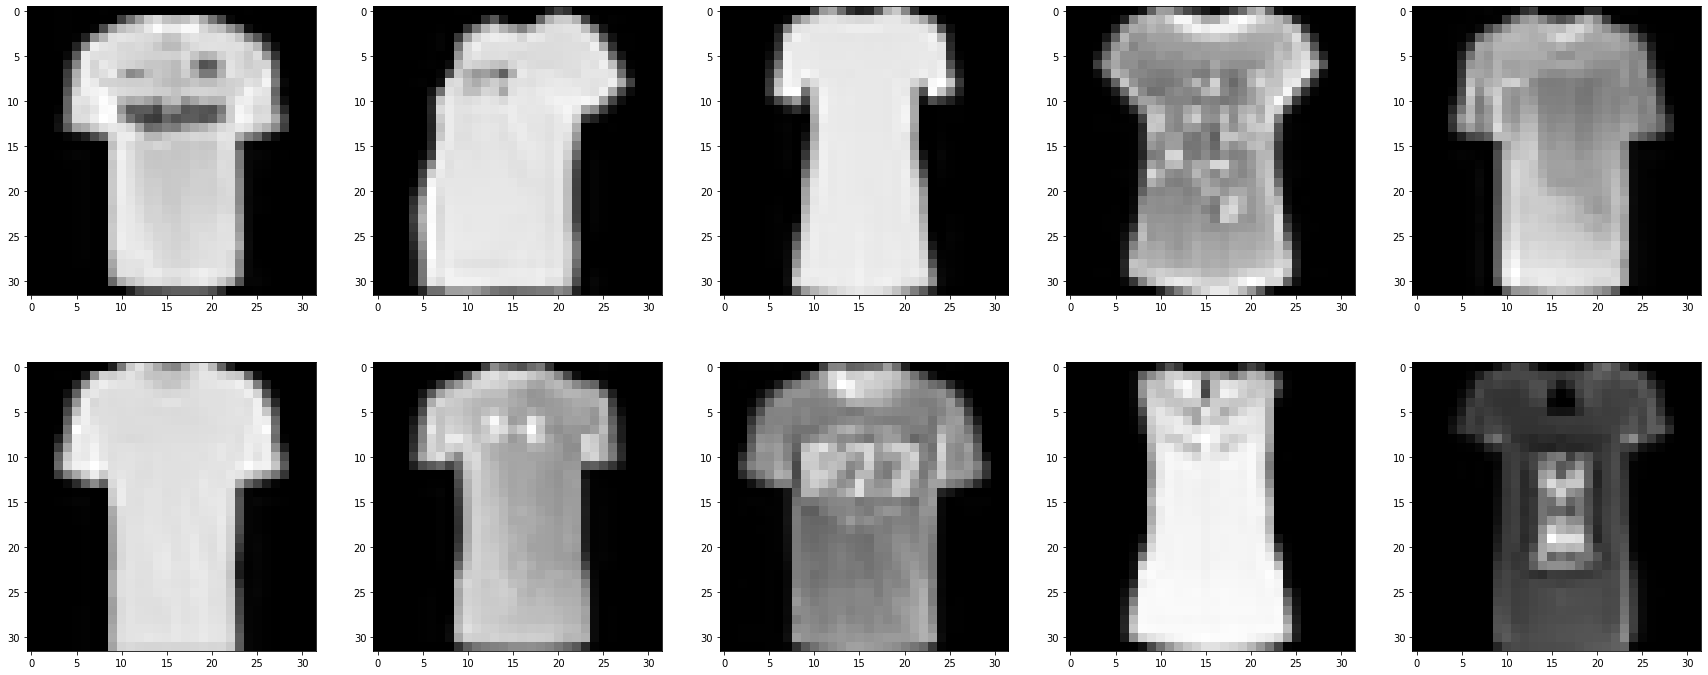

In [133]:
# ----- adjustable parameters ----- #
true_class = 6
misclassified_class = 4
display_num = 10
# --------------------------------- #

print("")
print(f"the samples of '{class_labels[true_class]}' which are classified as '{class_labels[misclassified_class]}''")
print("")
fig = plt.figure(figsize=(30, 12))
miss_index_list = np.arange(len(labels))[np.array(np.array(pred_labels==misclassified_class, dtype=np.int) * np.array(labels==true_class, dtype=np.int), dtype=np.bool)]
for i in range(len(miss_index_list[:display_num])):
    ax = fig.add_subplot(2, 5, i+1)
    x, label = testset[miss_index_list[i]]
    ax.imshow(image_from_numpy(cuda2numpy(x[np.newaxis]))[0])

---
Although we can tell the unclear neutral audio, it relatively has intention and it might lead the missclassfication.
However, it means the model somewhat refer to the intention of the audio, so let's observe the detail in next notebook!

---

# training

- assignment
    - implementation of ResNet